In [11]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

try:
    df
except NameError:
    import ccxt
    ex = ccxt.binance({'enableRateLimit': True})
    ohlcv = ex.fetch_ohlcv('BTC/USDT', timeframe='15m', limit=3000)
    df = pd.DataFrame(ohlcv, columns=['ts','open','high','low','close','vol'])
    df['ts'] = pd.to_datetime(df['ts'], unit='ms', utc=True)
    df = df.set_index('ts').tz_convert('Asia/Tokyo')

print("df:", df.shape, df.index.min(), "→", df.index.max())


df: (1000, 5) 2025-09-10 08:15:00+09:00 → 2025-09-20 18:00:00+09:00


In [12]:
ret = np.log(df['close']).diff()

X = pd.DataFrame(index=df.index)
X['r1']=ret
X['r2']=ret.shift(1)
X['r3']=ret.shift(2)
ema12=df['close'].ewm(span=12).mean(); ema26=df['close'].ewm(span=26).mean()
X['macd']=ema12-ema26
X['vol20']=ret.rolling(20).std()
X['vol60']=ret.rolling(60).std()
X['bbw']=(df['close'].rolling(20).mean().sub(df['close']))/df['close'].rolling(20).std()

H=3  # 3本先
fwd = np.log(df['close']).shift(-H) - np.log(df['close'])
y = (fwd>0).astype(int)

data = pd.concat([X, y.rename('y'), fwd.rename('fwd')], axis=1).dropna()
data.tail()


,r1,r2,r3,macd,vol20,vol60,bbw,y,fwd
ts,,,,,,,,,
2025-09-20 16:15:00+09:00,0.000435,-0.000116,0.000197,36.068991,0.000445,0.000762,-1.613593,1,0.001023
2025-09-20 16:30:00+09:00,0.001625,0.000435,-0.000116,55.093779,0.000561,0.000790,-2.703032,0,-0.000936
2025-09-20 16:45:00+09:00,0.000370,0.001625,0.000435,72.793613,0.000562,0.000785,-2.403626,0,-0.000729
2025-09-20 17:00:00+09:00,-0.000971,0.000370,0.001625,76.849909,0.000559,0.000731,-1.431922,0,-0.001335
2025-09-20 17:15:00+09:00,-0.000335,-0.000971,0.000370,76.056182,0.000570,0.000732,-1.055093,0,-0.000883


In [13]:
def walk_forward_probs(X, y, step=200, start_ratio=0.6):
    n=len(y); res=[]
    start=int(n*start_ratio)
    for cut in range(start, n-step, step):
        tr = slice(0, cut)
        te = slice(cut, min(cut+step, n))
        pipe = Pipeline([
            ('sc', StandardScaler()),
            ('lr', LogisticRegression(max_iter=300, C=0.5, penalty='l2'))
        ])
        pipe.fit(X.iloc[tr], y.iloc[tr])
        p = pipe.predict_proba(X.iloc[te])[:,1]
        res.append(pd.DataFrame({'proba_up':p}, index=X.index[te]))
    return pd.concat(res)

oos = walk_forward_probs(data[X.columns], data['y'])
oos = oos.join(data['fwd'], how='left')
oos.tail()


,proba_up,fwd
ts,,
2025-09-18 20:30:00+09:00,0.532159,0.001023
2025-09-18 20:45:00+09:00,0.508674,0.001247
2025-09-18 21:00:00+09:00,0.488346,-0.001016
2025-09-18 21:15:00+09:00,0.529780,0.001125
2025-09-18 21:30:00+09:00,0.563005,0.002011


Sharpe≈ -26.58  MaxDD≈ -0.059  Trades≈ 75


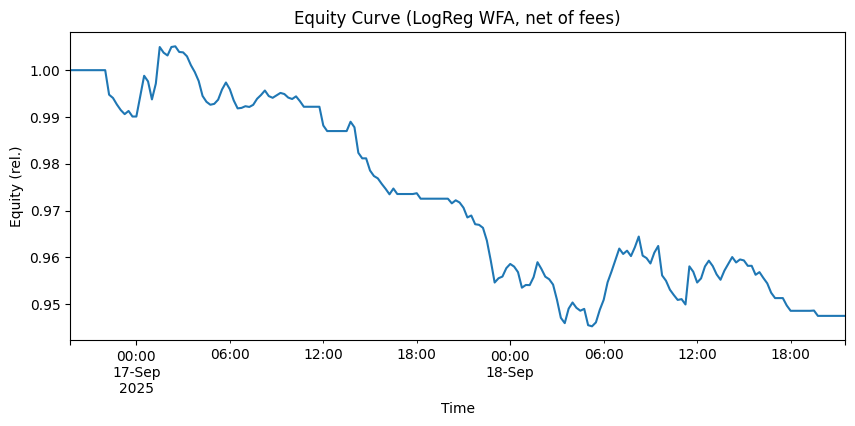

In [14]:
th=0.55            # 閾値（まずは固定）
fee=0.0010         # 片道手数料 0.10%
slip=0.0002        # 片道スリッページ 0.02%
ann = np.sqrt(365*24*4)  # 15分足ざっくり年換算

sig = (oos['proba_up']>th).astype(int) - (oos['proba_up']<(1-th)).astype(int)
gross = sig.shift(1).fillna(0) * oos['fwd']     # 未来を見ない
turn  = sig.diff().abs().fillna(0)
cost  = turn.shift(1).fillna(0) * (fee+slip)
net   = (gross - cost).dropna()
eq    = (1+net).cumprod()

sharpe = float(net.mean()/net.std()*ann) if net.std()!=0 else float('nan')
maxdd  = float((eq/eq.cummax()-1).min())
print(f"Sharpe≈ {sharpe:.2f}  MaxDD≈ {maxdd:.3f}  Trades≈ {int(turn.sum())}")

plt.figure(figsize=(10,4))
eq.plot()
plt.title('Equity Curve (LogReg WFA, net of fees)')
plt.xlabel('Time'); plt.ylabel('Equity (rel.)')
plt.show()


In [15]:
def eval_threshold(th):
    s = (oos['proba_up']>th).astype(int) - (oos['proba_up']<(1-th)).astype(int)
    g = s.shift(1).fillna(0)*oos['fwd']
    t = s.diff().abs().fillna(0)
    c = t.shift(1).fillna(0)*(fee+slip)
    n = (g-c).dropna()
    if n.std()==0: return th, np.nan, np.nan, int(t.sum())
    sh = float(n.mean()/n.std()*ann)
    dd = float(((1+n).cumprod()/ (1+n).cumprod().cummax()-1).min())
    return th, sh, dd, int(t.sum())

ths = np.round(np.linspace(0.50,0.65,16),3)
res = [eval_threshold(t) for t in ths]
pd.DataFrame(res, columns=['th','sharpe','maxdd','trades']).set_index('th')


,sharpe,maxdd,trades
th,,,
0.50,-14.666191,-0.066430,84
0.51,-22.366019,-0.063097,87
0.52,-25.185121,-0.066861,89
0.53,-19.927660,-0.054877,85
0.54,-14.927974,-0.049269,79
0.55,-26.582093,-0.059491,75
0.56,-25.906169,-0.058807,83
0.57,-26.302865,-0.057896,74
0.58,-36.319072,-0.069530,68
